### This colab notebook is for the deep learning project(Group 20).
### dataset: https://github.com/Hua-YS/AID-Multilabel-Dataset
### Author: Cheng Huang, Zhiwei Zeng, Haoyu Guo

In this project, we will use the AID-Multilabel-Dataset, a dataset for multi-label classification of remote sensing images to do the multi-label classification task. However, due to the label positive, negative imblance probelm, we will build three some models based on three different loss functions(Binary cross entropy, Focal Loss, Asymmetric Loss) to evaluate the performance.


## Install required packages

In [ ]:
!pip3 install wheels
!pip3 install pandas
!python3 -m pip install matplotlib
!pip3 install tqdm
!pip3 install scikit-learn
!pip3 install pandas

## Import required packages

In [50]:
import torchvision.models as models
from torch import nn
import torch
from torch.utils.data.dataset import Dataset
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import copy
# Imports for calculating metrics
from PIL import *
from sklearn.metrics import f1_score, recall_score, precision_score
import torch.nn.functional as F

## Change to GPU

In [33]:
# It's very important here because we use Mac M1 chip to train so we use 'mps' here
# If you use Nvidia, please use CUDA
device = torch.device('mps')

In [34]:
device

device(type='mps')

## Global Variables

In [35]:
# AID Dataser
## Training set path
training_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_tr/'
## test set path
test_path = '/Users/huangcheng/Documents/newAIDDataset/images/images_test/'
## the number of classes
num_class = 17
## csv path
data_csv = '/Users/huangcheng/Documents/newAIDDataset/newlabelfinal.csv'

batch_size =32
num_epoch = 14

## Import CSV Files

In [36]:
cats = pd.read_csv(data_csv, header=None)
cats = list(cats[0])
cats = cats[1:]

In [37]:
data = pd.read_csv(data_csv)
data.head()

,IMAGE\LABEL,airplane,bare-soil,buildings,cars,chaparral,court,dock,field,grass,mobile-home,pavement,sand,sea,ship,tanks,trees,water
0,airport_1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
1,airport_2,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0
2,airport_3,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
3,airport_4,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4,airport_5,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0


## Create the model (VGG16 + ower own top layer)

In [91]:
def set_parameter_requires_grad(model):
    for name, param in model_ft.named_parameters():
        if "classifier.6.weight" in name or "classifier.6.bias" in name: #or "classifier.0.weight" in name or "classifier.0.bias" in name or "classifier.3.weight" in name or "classifier.3.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

In [92]:
## approach 1
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# num_ftrs = model_ft.classifier[0].in_features  
# model_ft.classifier = nn.Linear(num_ftrs,num_class)
# model_ft.to(device)
# print(model_ft)

# # approach 2
# model_ft = models.vgg16(pretrained=True)
# set_parameter_requires_grad(model_ft, True)
# model_ft.classifier.add_module('add_linear', nn.Linear(1000, num_class))
# model_ft.to(device)
# print(model_ft)

# approach 3
model_ft = models.vgg16(pretrained=True)
set_parameter_requires_grad(model_ft)
model_ft.classifier[6] = nn.Linear(4096, num_class)
model_ft.to(device)
print(model_ft)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/pytorchlearn/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Image normalization layer

In [78]:
# Transformations on the data
# transformations = transforms.Compose([transforms.Resize((224, 224)),
#                                       transforms.ToTensor(),
#                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#                                      ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5), 
        transforms.ColorJitter(brightness=0.1),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## DataLoader

In [79]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transformations, train):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
            train: flag to determine if train or val set
        """
        # Transforms
        self.transforms = transformations
        # Read the csv file
        self.data_info = pd.read_csv(csv_path)
        self.train = train
        # First column contains the image paths
        if train:
            self.image_arr = (self.data_info.iloc[0:2400, 0])
        else:
            self.image_arr = (self.data_info.iloc[2400:2700, 0])
  
        self.image_arr = np.asarray(self.image_arr)
        # Second column is the labels
        if train:
            self.label_arr = np.asarray(self.data_info.iloc[0:2400, 1:])
        else:
            self.label_arr = np.asarray(self.data_info.iloc[2400:2700, 1:])

        # Third column is for an operation indicator
        #self.operation_arr = np.asarray(self.data_info.iloc[:, 2])
        # Calculate len
        self.data_len = len(self.label_arr)

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = training_path+self.image_arr[index] + ".jpg"
        # Open image
        img_as_img = Image.open(single_image_name).convert('RGB')

        if self.transforms is not None and self.train == True:
            img_as_tensor = self.transforms['train'](img_as_img)
        if self.transforms is not None and self.train == False:
            img_as_tensor = self.transforms['val'](img_as_img)
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, single_image_label)

    def __len__(self):
        return self.data_len

In [80]:
# Define a dictionary of dataset
# one for train and one for validation
image_datasets = {'train': CustomDatasetFromCSV(data_csv, data_transforms, True), 
                 'val': CustomDatasetFromCSV(data_csv, data_transforms, False)}


In [81]:
# Define data loader
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True, 
                                                   num_workers=0) for x in ['train', 'val']}

## Map image name and label

In [82]:
# all_data_csv = '/Users/huangcheng/Documents/newAIDDataset/multilabel.csv'
# all_data_csv = '/Users/huangcheng/Downloads/hbku/labels/labels_train.csv'
labels = pd.read_csv(data_csv)
name_label_dic = {}
labels.iloc[1]
for i in tqdm(range(labels.shape[0])):
  label = []
  for j in range(1, num_class+1):
    label.append(labels.iloc[i][j])
  name_label_dic[labels.iloc[i][0]] = label


100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1812.80it/s]


## Calculate Accuracy Function

In [83]:
# Function for calculating accuracy of the model
def calc_accuracy(preds, labels):
    return (np.sum(np.around(preds.cpu().detach().numpy()) == labels.cpu().detach().numpy()))

## Plot Loss Function

In [84]:
def draw_plot(train_loss, val_loss, num_epoch):
    epoch_range = range(1, num_epoch+1)
    plt.plot(epoch_range, train_loss)
    plt.plot(epoch_range, val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()


## Evaluate the model(Precision, Recall, F1 Score)

In [85]:
def experiment_evaluate(model_ft):
    y_true = []
    y_predict = []
    
    for img_name in tqdm(os.listdir(test_path)):
        if img_name.endswith(".jpg") == False:
          continue;
        img_path = test_path + img_name
        sample_img = Image.open(img_path).convert('RGB')
        img_tensor = data_transforms['val'](sample_img)
        img_tensor = img_tensor.reshape(1, 3, 224, 224)
        true_label = name_label_dic[img_name[:-4]]
        y_true.append(true_label)
        model_ft.eval()
        with torch.no_grad():
            img_tensor_tensor = img_tensor.to(device)
            outputs = model_ft(img_tensor_tensor)
            outputs = torch.sigmoid(outputs)
            preds_label = np.around(outputs.cpu().detach().numpy())[0].tolist()
            y_predict.append(preds_label)
    
    precision = precision_score(y_true, y_predict, average=None, zero_division=1)
    recall = recall_score(y_true, y_predict, average=None, zero_division=1)
    f1 = f1_score(y_true, y_predict, average=None, zero_division=1)
    
    precision_micro = precision_score(y_true, y_predict, zero_division=1, average = 'micro')
    recall_micro = recall_score(y_true, y_predict, zero_division=1, average = 'micro')    
    f1_micro = f1_score(y_true, y_predict, zero_division=1, average = 'micro')
    
    return precision, recall, f1, precision_micro, recall_micro, f1_micro


## Train Model Function

In [86]:
def train_model(model, dataloaders, criterion, optimizer, num_epoch=25):
  '''
      model: Model need to train
      dataloaders: dataloaders to get data
      criterion: Loss function(we will use three differernt loss function, Binary Cross Entropy, Focal Loss and ASL)
      optimizer: we use Adam here
      num_epoch: the default num_epoch is 25
  '''
  since = time.time()
  val_acc_history = []
  loss_train = []
  loss_val = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epoch):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in tqdm(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels = labels.float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        # In validation phase, we will not calculate the gradiant, so set it to false can reduce memory consumption
        with torch.set_grad_enabled(phase == 'train'): 
          # Get model outputs and calculate loss
          outputs = model(inputs)
          outputs = torch.sigmoid(outputs)
          loss = criterion(outputs, labels)
          preds = outputs
          
          if phase == 'train':
            loss.backward() # back propagation to calculate the grad
            optimizer.step() # optimize the weight
          
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += calc_accuracy(preds, labels.data)
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)      
      if phase == 'train':
        loss_train.append(epoch_loss)
      if phase == 'val':
        loss_val.append(epoch_loss)
      print('epoch:{} {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  model.load_state_dict(best_model_wts)
  return model, loss_train, loss_val

## Here we train the model with Adam and Binary Cross Entropy

In [19]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
bce_optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
# Binary Cross Entropy loss function
bce_criterion = torch.nn.BCELoss().to(device)
bce_model, bce_train_loss, bce_val_loss = train_model(model_ft, dataloaders_dict, bce_criterion, bce_optimizer, num_epoch=num_epoch)


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:0 train Loss: 0.2751 Acc: 15.1013


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:0 val Loss: 0.2154 Acc: 15.5433


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:1 train Loss: 0.2063 Acc: 15.5875


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:1 val Loss: 0.2028 Acc: 15.6700


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:2 train Loss: 0.1914 Acc: 15.6813


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:2 val Loss: 0.1945 Acc: 15.7400


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.21it/s]


epoch:3 train Loss: 0.1833 Acc: 15.7662


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:3 val Loss: 0.1861 Acc: 15.7800


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:4 train Loss: 0.1800 Acc: 15.7637


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:4 val Loss: 0.1834 Acc: 15.8300


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:5 train Loss: 0.1790 Acc: 15.7792


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


epoch:5 val Loss: 0.1835 Acc: 15.8400


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.21it/s]


epoch:6 train Loss: 0.1701 Acc: 15.8283


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:6 val Loss: 0.1828 Acc: 15.8000


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:7 train Loss: 0.1710 Acc: 15.8500


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:7 val Loss: 0.1818 Acc: 15.8233


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:8 train Loss: 0.1684 Acc: 15.8333


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


epoch:8 val Loss: 0.1780 Acc: 15.8567


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:9 train Loss: 0.1665 Acc: 15.8521


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:9 val Loss: 0.1809 Acc: 15.8233


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:10 train Loss: 0.1628 Acc: 15.8796


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:10 val Loss: 0.1835 Acc: 15.8500


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:11 train Loss: 0.1624 Acc: 15.8796


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:11 val Loss: 0.1776 Acc: 15.8700


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.21it/s]


epoch:12 train Loss: 0.1645 Acc: 15.8629


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:12 val Loss: 0.1822 Acc: 15.8833


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:13 train Loss: 0.1594 Acc: 15.9096


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

epoch:13 val Loss: 0.1776 Acc: 15.8933


## Plot the Loss with Binary Cross Entropy

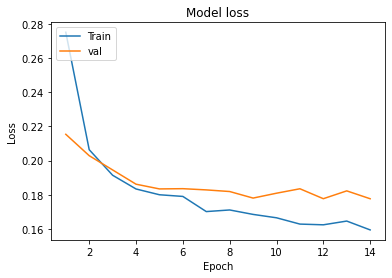

In [20]:
draw_plot(bce_train_loss, bce_val_loss, num_epoch)

In [119]:
torch.save(bce_model,"/Users/huangcheng/Downloads/hbku/aid_lr0001_bs32/bce.pth")

## Evluate the Model with Binary Cross Entropy

In [31]:
precision, recall, f1, precision_micro, recall_micro, f1_micro  = experiment_evaluate(bce_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 21.95it/s]


[1.         0.71518987 0.96116505 0.9078341  0.75       0.56
 0.75       0.7        0.93495935 1.         0.96137339 1.
 0.83333333 0.66666667 0.75       0.92622951 0.58108108]
[0.4        0.79020979 0.93396226 0.95169082 0.16666667 0.37837838
 0.46153846 0.66666667 0.9787234  0.         0.97391304 0.76
 0.45454545 0.34782609 0.9        0.93004115 0.4673913 ]
[0.57142857 0.75083056 0.94736842 0.92924528 0.27272727 0.4516129
 0.57142857 0.68292683 0.95634096 0.         0.96760259 0.86363636
 0.58823529 0.45714286 0.81818182 0.92813142 0.51807229]
precision_micro =  0.881491344873502
recall_micro =  0.8514469453376206
f1_micro =  0.8662087013411841


## Focal Loss Function Class

In [87]:
class FocalLoss(nn.Module):

    def __init__(self, alpha=.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        p = inputs
        ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        return loss.mean()

## Here we train the model with Adam and Focal Loss

In [93]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
focal_optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
# Binary Cross Entropy loss function
focal_criterion = FocalLoss(alpha=.25, gamma=2).to(device)
focal_model, focal_train_loss, focal_val_loss = train_model(model_ft, dataloaders_dict, focal_criterion, focal_optimizer, num_epoch=25)

100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:0 train Loss: 0.0456 Acc: 13.0679


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:0 val Loss: 0.0279 Acc: 14.8133


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:1 train Loss: 0.0238 Acc: 14.2688


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:1 val Loss: 0.0239 Acc: 14.9767


100%|███████████████████████████████████████████| 75/75 [01:04<00:00,  1.16it/s]


epoch:2 train Loss: 0.0217 Acc: 14.4975


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:2 val Loss: 0.0222 Acc: 15.0167


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:3 train Loss: 0.0206 Acc: 14.6104


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:3 val Loss: 0.0208 Acc: 15.0167


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:4 train Loss: 0.0199 Acc: 14.6800


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:4 val Loss: 0.0200 Acc: 15.0467


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:5 train Loss: 0.0197 Acc: 14.6738


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:5 val Loss: 0.0195 Acc: 15.0400


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:6 train Loss: 0.0190 Acc: 14.7263


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:6 val Loss: 0.0191 Acc: 15.1100


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:7 train Loss: 0.0185 Acc: 14.7979


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:7 val Loss: 0.0185 Acc: 15.0867


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:8 train Loss: 0.0181 Acc: 14.8063


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:8 val Loss: 0.0182 Acc: 15.1700


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:9 train Loss: 0.0176 Acc: 14.8679


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:9 val Loss: 0.0178 Acc: 15.1900


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:10 train Loss: 0.0175 Acc: 14.8517


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:10 val Loss: 0.0175 Acc: 15.2067


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:11 train Loss: 0.0170 Acc: 14.9138


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:11 val Loss: 0.0172 Acc: 15.2300


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:12 train Loss: 0.0169 Acc: 14.9271


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:12 val Loss: 0.0169 Acc: 15.2233


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:13 train Loss: 0.0166 Acc: 14.9392


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:13 val Loss: 0.0165 Acc: 15.2900


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.17it/s]


epoch:14 train Loss: 0.0163 Acc: 14.9671


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


epoch:14 val Loss: 0.0163 Acc: 15.3433


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:15 train Loss: 0.0162 Acc: 14.9987


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


epoch:15 val Loss: 0.0160 Acc: 15.3067


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:16 train Loss: 0.0161 Acc: 15.0388


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:16 val Loss: 0.0158 Acc: 15.3067


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:17 train Loss: 0.0157 Acc: 15.0542


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:17 val Loss: 0.0157 Acc: 15.3100


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.20it/s]


epoch:18 train Loss: 0.0154 Acc: 15.0762


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


epoch:18 val Loss: 0.0155 Acc: 15.3200


100%|███████████████████████████████████████████| 75/75 [01:02<00:00,  1.19it/s]


epoch:19 train Loss: 0.0154 Acc: 15.1050


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:19 val Loss: 0.0154 Acc: 15.3767


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:20 train Loss: 0.0153 Acc: 15.1167


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:20 val Loss: 0.0154 Acc: 15.3833


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:21 train Loss: 0.0151 Acc: 15.1442


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:21 val Loss: 0.0151 Acc: 15.3867


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:22 train Loss: 0.0150 Acc: 15.1358


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:22 val Loss: 0.0150 Acc: 15.4200


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.18it/s]


epoch:23 train Loss: 0.0150 Acc: 15.1438


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


epoch:23 val Loss: 0.0149 Acc: 15.4467


100%|███████████████████████████████████████████| 75/75 [01:03<00:00,  1.19it/s]


epoch:24 train Loss: 0.0149 Acc: 15.1583


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]

epoch:24 val Loss: 0.0148 Acc: 15.3867


## Plot the Loss with Focal Loss

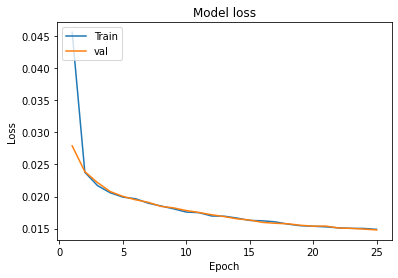

In [94]:
draw_plot(focal_train_loss, focal_val_loss, 25)

## Evluate the Model with Focal Loss

In [95]:
precision, recall, f1, precision_micro, recall_micro, f1_micro = experiment_evaluate(focal_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.15it/s]


[1.         0.83018868 0.96969697 0.94300518 1.         0.71428571
 1.         0.90909091 0.96244131 1.         0.96846847 1.
 1.         1.         1.         0.93665158 1.        ]
[0.         0.30769231 0.90566038 0.87922705 0.         0.13513514
 0.15384615 0.47619048 0.87234043 0.         0.93478261 0.44
 0.22727273 0.13043478 0.4        0.85185185 0.17391304]
[0.         0.44897959 0.93658537 0.91       0.         0.22727273
 0.26666667 0.625      0.91517857 0.         0.95132743 0.61111111
 0.37037037 0.23076923 0.57142857 0.89224138 0.2962963 ]
precision_micro =  0.9500430663221361
recall_micro =  0.7093247588424437
f1_micro =  0.8122238586156113


## ASL Loss Function Class

In [33]:
class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
        # Calculating Probabilities
        x_sigmoid = x
        xs_pos = x_sigmoid
        xs_neg = 1 - x_sigmoid

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


## Here we train the model with Adam and ASL

In [145]:
# The first parameter is the model's parameter that need to train
# The second parameter is the learning rate
asl_optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
# Binary Cross Entropy loss function
asl_criterion = AsymmetricLoss(gamma_neg=2, gamma_pos=1, clip=0).to(device)
asl_model, asl_train_loss, asl_val_loss = train_model(model_ft, dataloaders_dict, asl_criterion, asl_optimizer, num_epoch=num_epoch)

100%|█████████████████████████████████████████| 300/300 [01:05<00:00,  4.60it/s]


epoch:0 train Loss: 8.3593 Acc: 15.9817


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:0 val Loss: 13.4085 Acc: 15.6733


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.52it/s]


epoch:1 train Loss: 8.4509 Acc: 15.9833


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:1 val Loss: 12.3881 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:2 train Loss: 9.1749 Acc: 15.9392


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:2 val Loss: 12.5390 Acc: 15.7967


100%|█████████████████████████████████████████| 300/300 [01:05<00:00,  4.55it/s]


epoch:3 train Loss: 9.2882 Acc: 15.9404


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


epoch:3 val Loss: 13.3908 Acc: 15.7400


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:4 train Loss: 9.5494 Acc: 15.9167


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:4 val Loss: 12.5986 Acc: 15.8300


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.52it/s]


epoch:5 train Loss: 9.8147 Acc: 15.9337


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.59it/s]


epoch:5 val Loss: 13.8882 Acc: 15.7333


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.53it/s]


epoch:6 train Loss: 9.3915 Acc: 15.9563


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:6 val Loss: 14.0136 Acc: 15.7933


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.51it/s]


epoch:7 train Loss: 9.8295 Acc: 15.9413


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:7 val Loss: 13.8897 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:8 train Loss: 9.2443 Acc: 15.9621


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:8 val Loss: 13.9992 Acc: 15.7667


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:9 train Loss: 9.7586 Acc: 15.9308


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:9 val Loss: 13.5180 Acc: 15.8267


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s]


epoch:10 train Loss: 9.9880 Acc: 15.9371


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.58it/s]


epoch:10 val Loss: 14.4672 Acc: 15.8133


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.53it/s]


epoch:11 train Loss: 10.3039 Acc: 15.9046


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.60it/s]


epoch:11 val Loss: 13.4157 Acc: 15.8100


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.49it/s]


epoch:12 train Loss: 10.0242 Acc: 15.9258


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.57it/s]


epoch:12 val Loss: 14.9180 Acc: 15.8567


100%|█████████████████████████████████████████| 300/300 [01:06<00:00,  4.51it/s]


epoch:13 train Loss: 9.8978 Acc: 15.9746


100%|███████████████████████████████████████████| 38/38 [00:08<00:00,  4.50it/s]

epoch:13 val Loss: 14.4166 Acc: 15.8267


## Save Model

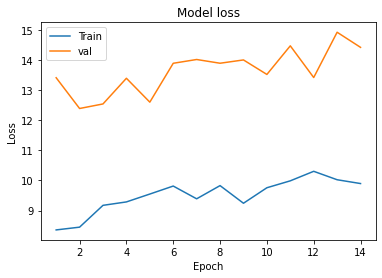

[8.359346409638723, 8.45092772046725, 9.17492939511935, 9.288181026776632, 9.54939340988795, 9.814677669604619, 9.39150926510493, 9.829498618443807, 9.244297788143157, 9.758563186526299, 9.987984421253204, 10.303865460554759, 10.02416127840678, 9.897778488000235]
[13.408462320963542, 12.388080501556397, 12.539042002360025, 13.390822054545085, 12.598635133107503, 13.88820925394694, 14.013565969467162, 13.88972250620524, 13.999203898111979, 13.518046925862631, 14.467167930603027, 13.415689633687338, 14.918022842407227, 14.416557280222575]


In [146]:
draw_plot(asl_train_loss, asl_val_loss, num_epoch)

print(asl_train_loss)
print(asl_val_loss)

## Evaluate the Model with ASL

In [147]:
precision, recall, f1, precision_micro, recall_micro, f1_micro = experiment_evaluate(asl_model)
print(precision)
print(recall)
print(f1)

print("precision_micro = ", precision_micro)
print("recall_micro = ", recall_micro)
print("f1_micro = ", f1_micro)

100%|█████████████████████████████████████████| 301/301 [00:13<00:00, 22.34it/s]

[1.         0.65591398 0.93150685 0.935      0.         0.40540541
 0.8125     0.8125     0.90551181 1.         0.94560669 1.
 0.86666667 0.5625     0.63636364 0.90769231 0.68253968]
[0.4        0.85314685 0.96226415 0.90338164 0.         0.40540541
 0.5        0.61904762 0.9787234  0.         0.9826087  0.76
 0.59090909 0.39130435 0.7        0.97119342 0.4673913 ]
[0.57142857 0.74164134 0.94663573 0.91891892 0.         0.40540541
 0.61904762 0.7027027  0.9406953  0.         0.96375267 0.86363636
 0.7027027  0.46153846 0.66666667 0.93836978 0.55483871]
avg precision =  0.7682180607095107
avg recall =  0.6167868193931593
avg f1 =  0.6469400548853038
